In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
df = pd.read_csv('https://raw.githubusercontent.com/ardahk/amex/main/data/final_data.csv')

/var/folders/rq/h4jkqywx1vsfcrq1cp88d7mh0000gn/T/ipykernel_72433/2473758751.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


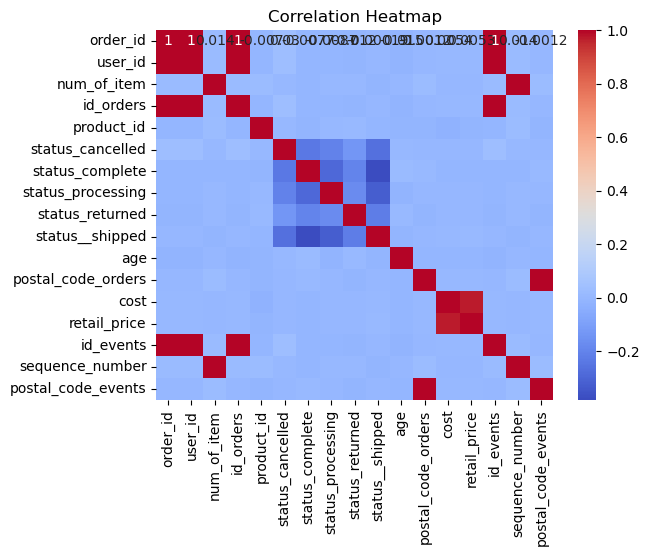

In [17]:
# Correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [20]:
selected_columns = ['age', 'gender', 'num_of_item', 'cost', 'traffic_source_orders', 'event_type']
cluster_data = df[selected_columns]
cluster_data = cluster_data.dropna(subset=['age', 'gender', 'num_of_item', 'cost', 'traffic_source_orders', 'event_type'])

### Feature Engineering

In [13]:
cluster_data['cost_per_item'] = cluster_data['cost'] / (cluster_data['num_of_item'] + 1)  # Avoid division by zero
cluster_data['order_success_rate'] = cluster_data['status_complete'] / (
    cluster_data[['status_complete', 'status_cancelled', 'status_returned']].sum(axis=1) + 1
)

In [21]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'num_of_item', 'cost']),  # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['gender', 'traffic_source_orders', 'event_type'])  # One-hot encode categorical features
    ]
)

# Transform data
cluster_data_preprocessed = preprocessor.fit_transform(cluster_data)

### Dimension Reduction

In [22]:
pca = PCA(n_components=2)
cluster_data_reduced = pca.fit_transform(cluster_data_preprocessed)

### Identify Optimal K for K-means Clustering

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

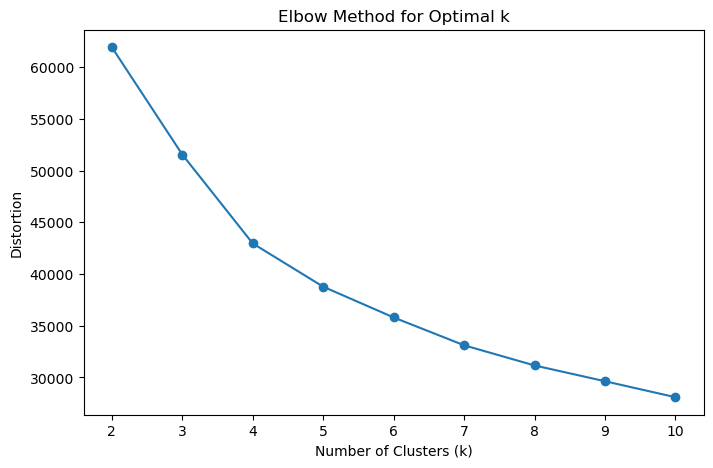

In [23]:
distortions = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_data_preprocessed)
    distortions.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal k')
plt.show()

In [24]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(cluster_data_preprocessed)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [25]:
silhouette_avg = silhouette_score(cluster_data_preprocessed, clusters)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.21032631876027508


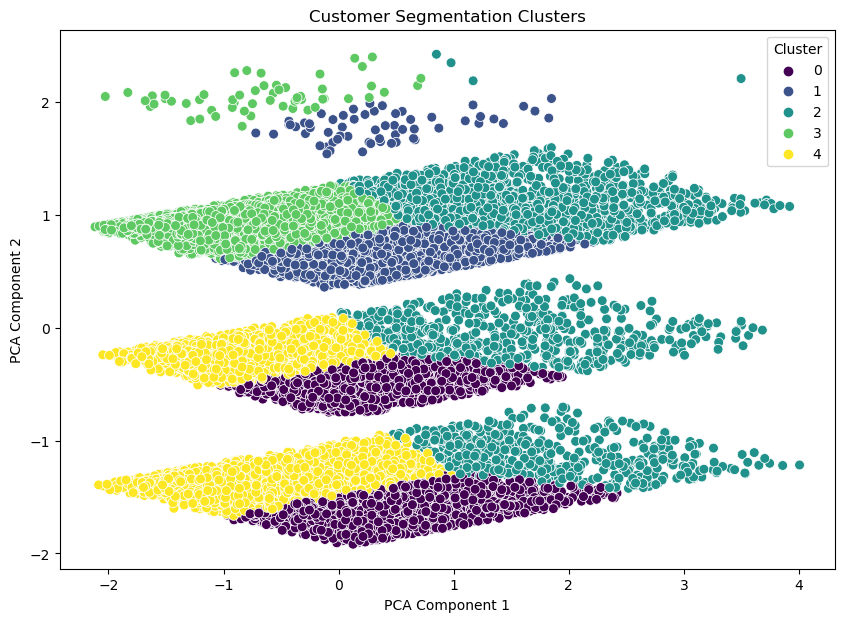

In [26]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=cluster_data_reduced[:, 0], y=cluster_data_reduced[:, 1], hue=clusters, palette='viridis', s=50)
plt.title('Customer Segmentation Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [30]:
from sklearn.cluster import DBSCAN

# Fit DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(cluster_data)

# Evaluate clusters
if len(set(dbscan_labels)) > 1:  # Avoid silhouette score if only one cluster is formed
    dbscan_silhouette = silhouette_score(cluster_data, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")
else:
    print("DBSCAN formed only one cluster; silhouette score not calculated.")

# Add DBSCAN labels to the dataset
cluster_data['dbscan_cluster'] = dbscan_labels

# Visualize the clusters
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
cluster_data_2d = pca.fit_transform(cluster_data)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=cluster_data_2d[:, 0], y=cluster_data_2d[:, 1], hue=dbscan_labels, palette='viridis', s=50)
plt.title('DBSCAN Cluster Visualization')
plt.show()


ValueError: could not convert string to float: 'F'

In [31]:
print(cluster_data.dtypes)

age                        int64
gender                    object
num_of_item                int64
cost                     float64
traffic_source_orders     object
event_type                object
dtype: object


In [32]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Create a copy to avoid modifying the original data
cluster_data_cleaned = cluster_data.copy()

# Identify categorical columns
categorical_columns = ['gender', 'traffic_source_orders', 'event_type']

# One-hot encode the categorical columns
encoded_data = pd.get_dummies(cluster_data_cleaned[categorical_columns], drop_first=True)

# Drop the original categorical columns and merge the encoded data
cluster_data_cleaned = cluster_data_cleaned.drop(columns=categorical_columns)
cluster_data_cleaned = pd.concat([cluster_data_cleaned, encoded_data], axis=1)

# Check the new structure of the dataset
print(cluster_data_cleaned.head())

   age  num_of_item       cost  gender_M  traffic_source_orders_Email  \
0   34            2  22.068000         0                            0   
1   22            2  15.513120         0                            0   
2   22            2  18.019851         0                            0   
3   32            3  18.019851         0                            0   
4   13            2  18.019851         0                            0   

   traffic_source_orders_Facebook  traffic_source_orders_Organic  \
0                               0                              0   
1                               1                              0   
2                               1                              0   
3                               0                              0   
4                               0                              0   

   traffic_source_orders_Search  
0                             1  
1                             0  
2                             0  
3               

In [33]:
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
cluster_data_normalized = scaler.fit_transform(cluster_data_cleaned)

In [34]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(cluster_data_normalized)

# Evaluate
if len(set(dbscan_labels)) > 1:
    silhouette_avg = silhouette_score(cluster_data_normalized, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {silhouette_avg}")
else:
    print("DBSCAN formed only one cluster.")

DBSCAN Silhouette Score: 0.11575124306765894


In [35]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=5, linkage='ward')
agg_labels = agg.fit_predict(cluster_data_normalized)

# Evaluate
agg_silhouette = silhouette_score(cluster_data_normalized, agg_labels)
print(f"Agglomerative Clustering Silhouette Score: {agg_silhouette}")

Agglomerative Clustering Silhouette Score: 0.2943373045924322


In [36]:
from sklearn.cluster import KMeans

# Apply K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(cluster_data_normalized)

# Evaluate
kmeans_silhouette = silhouette_score(cluster_data_normalized, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-Means Silhouette Score: 0.3061507114610886


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


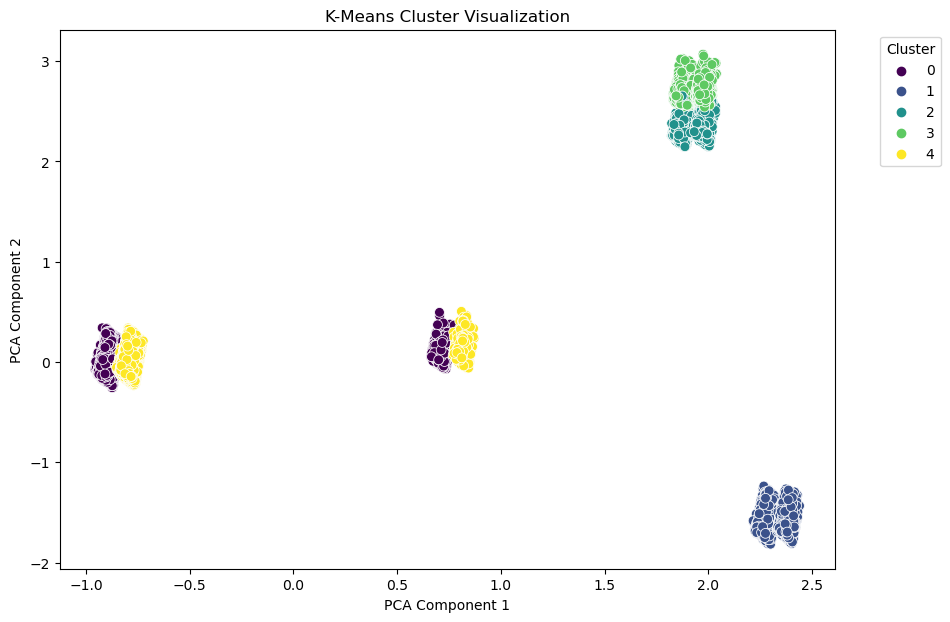

In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce dimensions for visualization
pca = PCA(n_components=5)
cluster_data_2d = pca.fit_transform(cluster_data_normalized)

# Plot K-Means clusters
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(cluster_data_normalized)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=cluster_data_2d[:, 0], y=cluster_data_2d[:, 1], hue=kmeans_labels, palette='viridis', s=50)
plt.title('K-Means Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

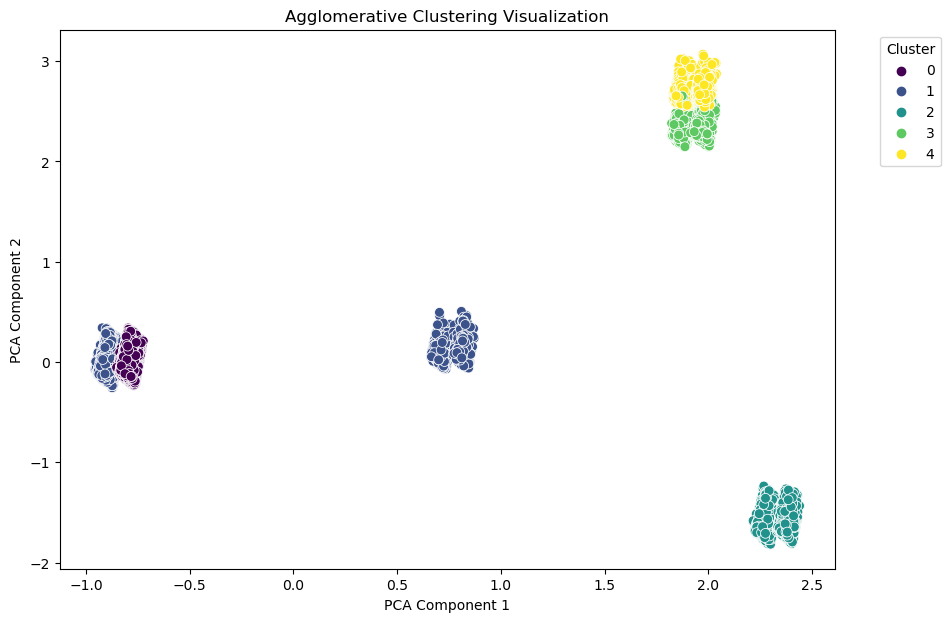

In [41]:
# Plot Agglomerative Clusters
agg = AgglomerativeClustering(n_clusters=5, linkage='ward')
agg_labels = agg.fit_predict(cluster_data_normalized)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=cluster_data_2d[:, 0], y=cluster_data_2d[:, 1], hue=agg_labels, palette='viridis', s=50)
plt.title('Agglomerative Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [39]:
cluster_data['kmeans_cluster'] = kmeans_labels
cluster_data['agg_cluster'] = agg_labels

# Analyze cluster summaries
print(cluster_data.groupby('kmeans_cluster').mean())
print(cluster_data.groupby('agg_cluster').mean())

                      age  num_of_item       cost  agg_cluster
kmeans_cluster                                                
0               41.241235     2.699434  22.043077     1.000000
1               41.486989     2.723893  23.093465     2.000000
2               40.992233     2.731068  23.411716     3.000000
3               41.640598     2.698594  23.876561     4.000000
4               40.901720     2.721236  24.469680     0.058717
                   age  num_of_item       cost  kmeans_cluster
agg_cluster                                                   
0            40.731175     2.721966  24.458954        4.000000
1            41.369576     2.699974  22.182356        0.214395
2            41.486989     2.723893  23.093465        1.000000
3            40.992233     2.731068  23.411716        2.000000
4            41.640598     2.698594  23.876561        3.000000


/var/folders/rq/h4jkqywx1vsfcrq1cp88d7mh0000gn/T/ipykernel_72433/973640301.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(cluster_data.groupby('kmeans_cluster').mean())
/var/folders/rq/h4jkqywx1vsfcrq1cp88d7mh0000gn/T/ipykernel_72433/973640301.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(cluster_data.groupby('agg_cluster').mean())
